In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 200)

%matplotlib inline


In [2]:
DATE_PATH = "../data/processed/dim_date_sample.csv"
CH_PATH   = "../data/processed/dim_channel_sample.csv"
FACT_PATH = "../data/processed/fact_funnel_by_date_channel_sample.csv"

date = pd.read_csv(DATE_PATH, parse_dates=['date_pk'])
ch   = pd.read_csv(CH_PATH)
fact = pd.read_csv(FACT_PATH)

print("date:", date.shape)
print("ch:  ", ch.shape)
print("fact:", fact.shape)

date.head()


date: (92, 6)
ch:   (12, 4)
fact: (828, 9)


,date_pk,year,month,month_name,week,day_name
0,2020-11-01,2020,11,November,44,Sunday
1,2020-11-02,2020,11,November,45,Monday
2,2020-11-03,2020,11,November,45,Tuesday
3,2020-11-04,2020,11,November,45,Wednesday
4,2020-11-05,2020,11,November,45,Thursday


## Business Questions (Phase 1)

1) Which **channel groups** drive the highest **conversion rate** (purchases / sessions)?
2) How do **sessions, purchases, revenue, conversion_rate** trend **daily**?
3) Which **source/medium** combos outperform their **channel group** average?
4) Which **days of week** and **months** perform best?
5) Is **AOV** (revenue / purchases) improving over time?

**Grain:** One row in the fact table = **date × channel**.  
**Tables:** `dim_date`, `dim_channel`, `fact_funnel_by_date_channel`.


##  Sanity Checks

Before analyzing, we validate:
- Primary keys in `dim_date` and `dim_channel` are unique.  
- No missing values in foreign keys of `fact_funnel`.  
- Compute `conversion_rate` (purchases / sessions).  
- Compute `AOV` (Average Order Value = revenue / purchases).  


In [3]:
issues = []

if not date['date_pk'].is_unique:
    issues.append("dim_date.date_pk is not unique ❌")

if not ch['channel_key'].is_unique:
    issues.append("dim_channel.channel_key is not unique ❌")

if fact['date_pk'].isna().any():
    issues.append("Null values in fact.date_pk ❌")

if fact['channel_key'].isna().any():
    issues.append("Null values in fact.channel_key ❌")

print("Sanity check issues:" if issues else "No obvious issues ✅")
for i in issues: 
    print(" -", i)

# Add derived metrics
fact['conversion_rate'] = (fact['purchases'] / fact['sessions']).replace([np.inf, -np.inf], np.nan)
fact['aov'] = (fact['revenue'] / fact['purchases']).replace([np.inf, -np.inf], np.nan)

fact[['sessions','add_to_cart','purchases','revenue','conversion_rate','aov']].describe()


No obvious issues ✅


,sessions,add_to_cart,purchases,revenue,conversion_rate,aov
count,828.000000,828.000000,828.000000,828.000000,825.000000,672.000000
mean,428.707729,70.704106,6.874396,437.397343,0.017695,60.978825
std,401.962308,99.474061,7.890648,595.017862,0.030323,41.170176
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,138.000000,0.000000,1.000000,23.500000,0.004739,37.371429
50%,301.000000,34.500000,4.000000,206.500000,0.011792,57.500000
75%,604.750000,101.000000,10.000000,606.500000,0.021739,75.161437
max,2366.000000,630.000000,41.000000,3821.000000,0.500000,450.000000


##  Join Fact and Dimensions

We join `fact_funnel` with `dim_date` and `dim_channel` to create a single analytics table.  
This will allow analysis by **time, channel_group, source, medium**.  


In [5]:
# Convert date_pk in fact to datetime
fact['date_pk'] = pd.to_datetime(fact['date_pk'], errors='coerce')

# Join fact with dimensions
f = (fact
     .merge(date[['date_pk','year','month','month_name','week','day_name']], 
            on='date_pk', how='left')
     .merge(ch[['channel_key','channel_group','source','medium']], 
            on='channel_key', how='left')
    )

print("Joined rows:", len(f))
f.head(3)


Joined rows: 828


,date_pk,channel_key,channel_group_x,sessions,add_to_cart,purchases,revenue,conversion_rate,aov,year,month,month_name,week,day_name,channel_group_y,source,medium
0,2020-11-01,1,Direct,611,0,6,332.0,0.009820,55.333333,2020,11,November,44,Sunday,Direct,(direct),(none)
1,2020-11-01,2,Organic Search,88,0,0,0.0,0.000000,NaN,2020,11,November,44,Sunday,Organic Search,<Other>,organic
2,2020-11-01,3,Organic Search,824,0,2,95.0,0.002427,47.500000,2020,11,November,44,Sunday,Organic Search,google,organic


##  Business Question 1: Which channels perform best?

We want to know which **channel groups** drive the strongest performance.
Metrics to compare:
- Total **sessions**
- Total **purchases**
- Total **revenue**
- **Conversion rate** = purchases / sessions


In [10]:
# --- Consolidate channel_group ---
cg_cols = [c for c in f.columns if c.startswith('channel_group')]
if len(cg_cols) == 2:
    # prefer non-null from _x, then _y
    f['channel_group'] = f[cg_cols[0]].fillna(f[cg_cols[1]])
    f = f.drop(columns=cg_cols)       # drop _x and _y
elif len(cg_cols) == 1:
    f['channel_group'] = f[cg_cols[0]]
    f = f.drop(columns=cg_cols)       # drop the original
else:
    # (rare) if neither exists, derive a simple grouping from medium
    f['channel_group'] = f['medium'].str.lower().map({
        'organic': 'Organic Search',
        'cpc': 'Paid Search', 'ppc': 'Paid Search',
        'paid': 'Paid Search', 'paid-search': 'Paid Search',
        'email': 'Email', 'affiliate': 'Affiliate',
        'referral': 'Referral', 'display': 'Display',
        'cpm': 'Display', 'banner': 'Display',
        '(none)': 'Direct', 'none': 'Direct', 'direct': 'Direct'
    }).fillna('Other')


In [11]:
by_channel = (f.groupby('channel_group', as_index=False)
                .agg(sessions=('sessions','sum'),
                     purchases=('purchases','sum'),
                     revenue=('revenue','sum')))
by_channel['conversion_rate'] = by_channel['purchases'] / by_channel['sessions']

by_channel.sort_values('conversion_rate', ascending=False)


,channel_group,sessions,purchases,revenue,conversion_rate
4,Referral,62178,1258,83521.0,0.020232
2,Other,73262,1445,85931.0,0.019724
0,Direct,82389,1251,79650.0,0.015184
1,Organic Search,121603,1572,104007.0,0.012927
3,Paid Search,15538,166,9056.0,0.010683


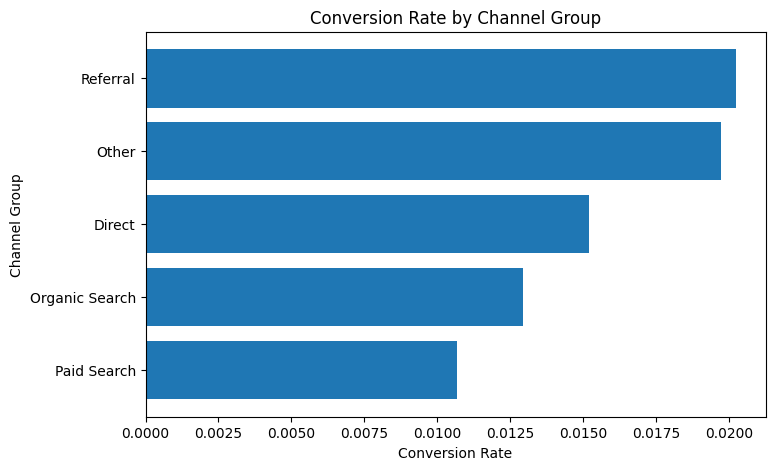

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
ordered = by_channel.sort_values('conversion_rate', ascending=False)
plt.barh(ordered['channel_group'], ordered['conversion_rate'])
plt.gca().invert_yaxis()
plt.title("Conversion Rate by Channel Group")
plt.xlabel("Conversion Rate")
plt.ylabel("Channel Group")
plt.show()


## Insights ##

**Referral traffic** has the highest conversion rate — visitors from referrals are more likely to complete purchases.

**Other traffic** sources also perform well, but represent a mixed bag (requires further breakdown).

**Direct traffic** performs better than Organic Search and Paid Search, showing loyal or intentional visitors convert more easily.

**Paid** Search has the lowest conversion rate, suggesting inefficiency — needs optimization (ad targeting, landing page quality, or campaign settings).

## Business implication ##:

Strengthen partnerships and affiliate programs (since referrals convert best).

Double down on loyalty/returning users (Direct).

Review and optimize marketing spend on Paid Search.

In [15]:
# Ensure we have a single 'channel_group' column to use
if 'channel_group' not in f.columns:
    if 'channel_group_x' in f.columns and 'channel_group_y' in f.columns:
        f['channel_group'] = f['channel_group_x'].fillna(f['channel_group_y'])
        f = f.drop(columns=['channel_group_x', 'channel_group_y'])
    elif 'channel_group_x' in f.columns:
        f['channel_group'] = f['channel_group_x']
        f = f.drop(columns=['channel_group_x'])
    elif 'channel_group_y' in f.columns:
        f['channel_group'] = f['channel_group_y']
        f = f.drop(columns=['channel_group_y'])
    else:
        # If nothing is found, show columns to debug
        print("No channel_group column found. Columns are:", f.columns.tolist())


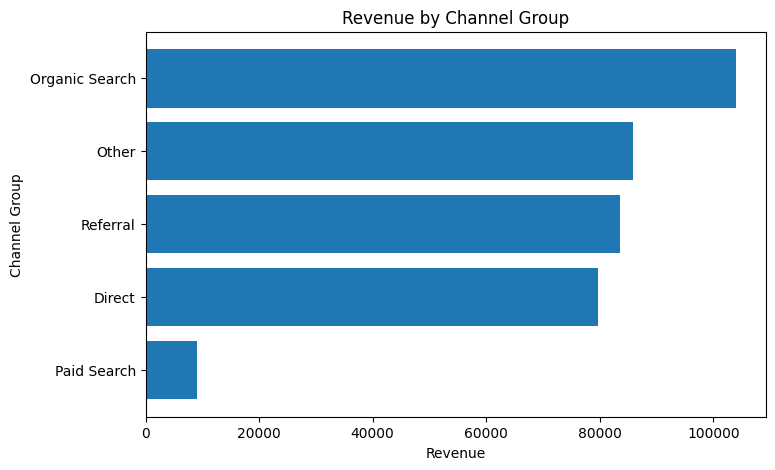

,channel_group,revenue
1,Organic Search,104007.0
2,Other,85931.0
4,Referral,83521.0
0,Direct,79650.0
3,Paid Search,9056.0


In [16]:
# Group by channel and sum revenue
revenue_by_channel = (
    f.groupby('channel_group', as_index=False)
     .agg(revenue=('revenue', 'sum'))
     .sort_values('revenue', ascending=False)
)

# Plot
plt.figure(figsize=(8,5))
plt.barh(revenue_by_channel['channel_group'], revenue_by_channel['revenue'])
plt.xlabel("Revenue")
plt.ylabel("Channel Group")
plt.title("Revenue by Channel Group")
plt.gca().invert_yaxis()
plt.show()

revenue_by_channel



## Insights:

**Organic Search** is the most profitable channel. This suggests strong SEO performance and high customer intent from search traffic.

**Referrals** also bring significant revenue (third), consistent with their high conversion rate (from Q1). → Shows referral traffic is both efficient and profitable.

**Paid Search** underperforms both in conversion (Q1) and revenue (Q2). This raises questions about campaign targeting, ad spend efficiency, and ROI.

Direct traffic (repeat customers, brand loyalty) also brings solid revenue, suggesting a strong base of returning customers.

## Business Question 3: Which channels are most effective overall?  

Here we combine **sessions, revenue, and conversion rate** in one visualization.  
- **X-axis = Sessions** → Traffic volume  
- **Y-axis = Revenue** → Profitability  
- **Bubble size = Conversion Rate** → Efficiency of converting visitors into buyers  

This chart helps identify the **best-performing channels** balancing both scale and efficiency.


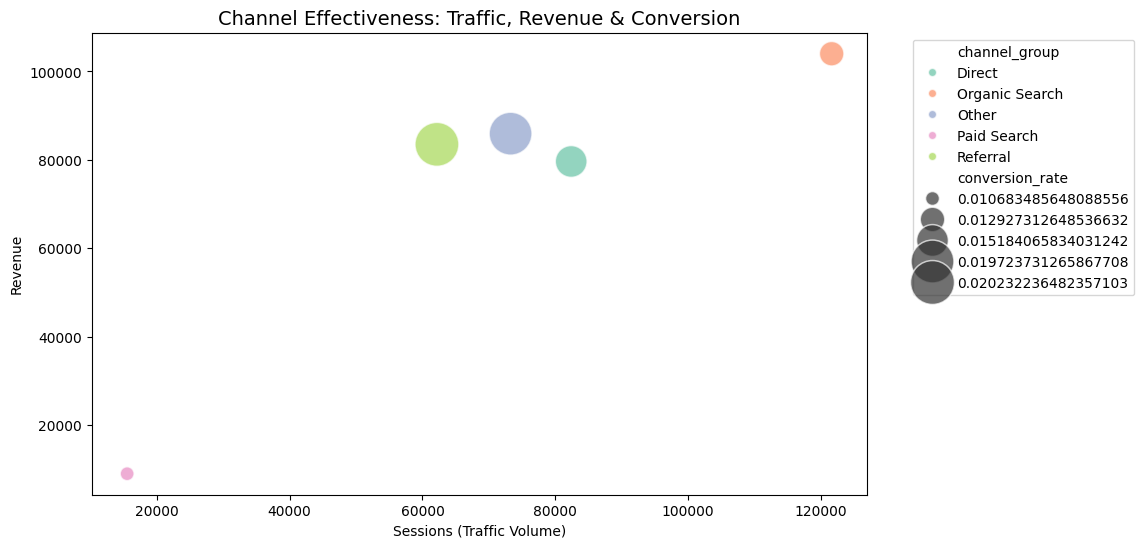

,channel_group,sessions,purchases,revenue,conversion_rate
0,Direct,82389,1251,79650.0,0.015184
1,Organic Search,121603,1572,104007.0,0.012927
2,Other,73262,1445,85931.0,0.019724
3,Paid Search,15538,166,9056.0,0.010683
4,Referral,62178,1258,83521.0,0.020232


In [18]:
import seaborn as sns

# Aggregate metrics by channel
bubble = (f.groupby('channel_group', as_index=False)
            .agg(sessions=('sessions','sum'),
                 purchases=('purchases','sum'),
                 revenue=('revenue','sum')))
bubble['conversion_rate'] = bubble['purchases'] / bubble['sessions']

# Bubble chart
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=bubble,
    x='sessions', 
    y='revenue', 
    size='conversion_rate',
    hue='channel_group',
    sizes=(100, 1000), # bubble size scaling
    alpha=0.7,
    palette='Set2'
)

plt.title("Channel Effectiveness: Traffic, Revenue & Conversion", fontsize=14)
plt.xlabel("Sessions (Traffic Volume)")
plt.ylabel("Revenue")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

bubble


### Insights:
- **Organic Search** drives the **largest traffic (121k sessions)** and **highest revenue (~104k)**, making it the **primary growth driver**.
- **Referral** has the **highest conversion rate (2.02%)**, meaning it converts fewer visitors but very efficiently.
- **Other** contributes solid revenue (~86k) with a strong conversion rate (~1.97%).
- **Direct traffic** is decent in both traffic and revenue but underperforms compared to Organic and Referral.
- **Paid Search** has **lowest revenue (~9k)** and **lowest traffic (~15k)** → suggests inefficient ad spend.

 **Strategic takeaway:**  
- Invest more in **Organic Search (SEO/Content)** to scale revenue.  
- Double down on **Referral partnerships** since they bring the best quality users.  
- Re-evaluate **Paid Search campaigns** — consider optimizing keywords or reducing spend.

# 2. Channel Analysis

In this section, we answer three key business questions about marketing channel performance.  
We focus on **conversion rate, revenue contribution, and overall funnel effectiveness**.


## Q1. Which channel has the highest conversion rate?

 **Finding:**  
Referral traffic achieves the **highest conversion rate (~2.02%)**, followed closely by "Other" channels (~1.97%).  
This shows that visitors coming from partner sites or external recommendations are most likely to complete a purchase.


## Q2. Which channel generates the most revenue?

 **Finding:**  
Organic Search is the **largest revenue driver (~104k)**.  
This highlights the importance of strong SEO and organic acquisition efforts.  

Other channels like Referral (~83k) and Direct (~80k) also contribute significantly, while Paid Search underperforms (~9k).


## Q3. Which channel is most effective overall (traffic + revenue + conversion)?

 **Finding:**  
- **Organic Search**: Best for scaling sales volume and total revenue.  
- **Referral**: Best for conversion efficiency (highest conversion rate).  
- **Direct**: Consistent, moderate performance.  
- **Paid Search**: Weakest performer (low revenue + low conversion).  



##  Strategic Takeaways

1. **Invest in SEO & Organic Search** → continue scaling the top revenue channel.  
2. **Strengthen Referral Partnerships** → leverage their high conversion rates.  
3. **Reassess Paid Search Campaigns** → optimize or reduce spending on underperforming ads.  

Together, these insights help align marketing spend with the **highest-ROI channels**.


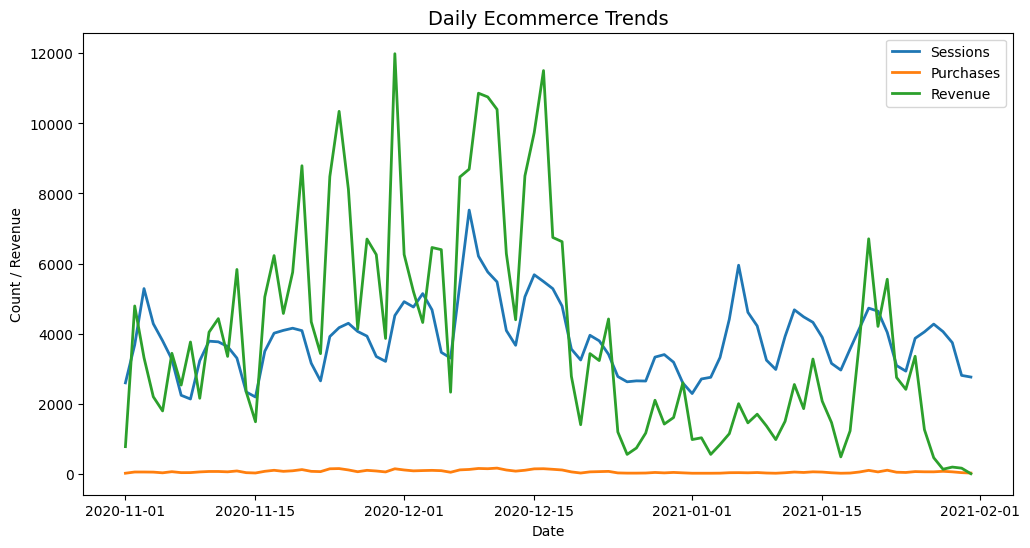

,date_pk,sessions,purchases,revenue
0,2020-11-01,2594,14,773.0
1,2020-11-02,3682,49,4789.0
2,2020-11-03,5285,49,3313.0
3,2020-11-04,4281,46,2197.0
4,2020-11-05,3795,26,1792.0


In [19]:
# Q4: Daily trends over time (sessions, purchases, revenue)
daily = (f.groupby('date_pk', as_index=False)
           .agg(sessions=('sessions','sum'),
                purchases=('purchases','sum'),
                revenue=('revenue','sum')))

# Plot sessions, purchases, and revenue trends
plt.figure(figsize=(12,6))
plt.plot(daily['date_pk'], daily['sessions'], label='Sessions', linewidth=2)
plt.plot(daily['date_pk'], daily['purchases'], label='Purchases', linewidth=2)
plt.plot(daily['date_pk'], daily['revenue'], label='Revenue', linewidth=2)

plt.title("Daily Ecommerce Trends", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Count / Revenue")
plt.legend()
plt.show()

daily.head()



## Q4. How do traffic and revenue evolve over time?

### Approach
- Aggregated **sessions, purchases, and revenue** by date.
- Visualized daily trends with line charts.

### Insights
- The chart highlights **peaks and troughs** in ecommerce activity.
- **Spikes in sessions** often align with **higher purchases and revenue**, showing strong traffic → sales correlation.
- Periods of low sessions usually bring lower revenue, except occasional anomalies (may indicate high-value customers or promotions).
- These patterns help identify **campaign impacts, seasonal spikes, or anomalies** in user behavior.


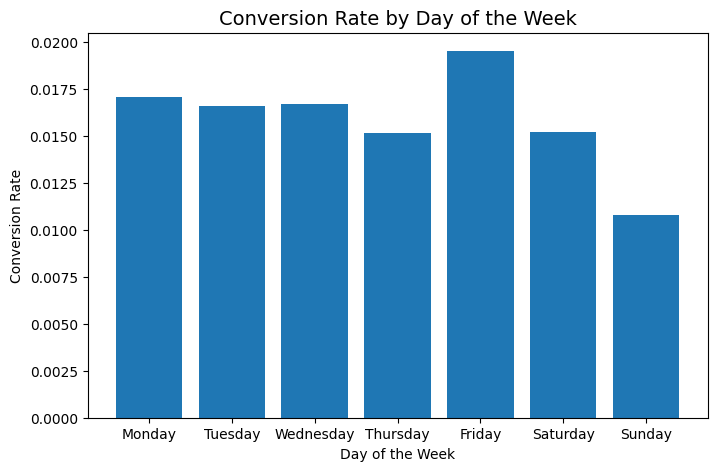

,day_name,sessions,purchases,conversion_rate
1,Monday,51242,874,0.017056
5,Tuesday,59848,991,0.016559
6,Wednesday,58910,982,0.016669
4,Thursday,54814,829,0.015124
0,Friday,50319,981,0.019496
2,Saturday,39823,604,0.015167
3,Sunday,40014,431,0.010771


In [20]:
# Q5: Conversion rate by day of the week
by_day = (f.groupby('day_name', as_index=False)
            .agg(sessions=('sessions','sum'),
                 purchases=('purchases','sum')))
by_day['conversion_rate'] = by_day['purchases'] / by_day['sessions']

# Reorder days of the week
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
by_day['day_name'] = pd.Categorical(by_day['day_name'], categories=day_order, ordered=True)
by_day = by_day.sort_values('day_name')

# Plot conversion rate by weekday
plt.figure(figsize=(8,5))
plt.bar(by_day['day_name'], by_day['conversion_rate'])
plt.title("Conversion Rate by Day of the Week", fontsize=14)
plt.xlabel("Day of the Week")
plt.ylabel("Conversion Rate")
plt.show()

by_day


## Q5. Do conversion rates differ by day of the week?

### Insights
- **Friday** shows the **highest conversion rate (~2.0%)**, suggesting end-of-week shopping intent.
- **Monday–Wednesday** maintain steady conversion rates (~1.65–1.7%).
- **Thursday** dips slightly, perhaps midweek distraction or fewer promotions.
- **Saturday and Sunday** show **lower conversion rates**, especially Sunday (~1.1%), indicating weaker purchase intent during weekends.
- Overall pattern: **weekday conversions outperform weekends**.

### Business Implications
- **Promotions and campaigns** should be concentrated toward **Thursday evening → Friday**, leveraging high conversion.
- **Weekend strategy** may need to focus on engagement/awareness rather than direct sales.
- Retargeting campaigns launched on weekends can drive conversions back during weekdays.


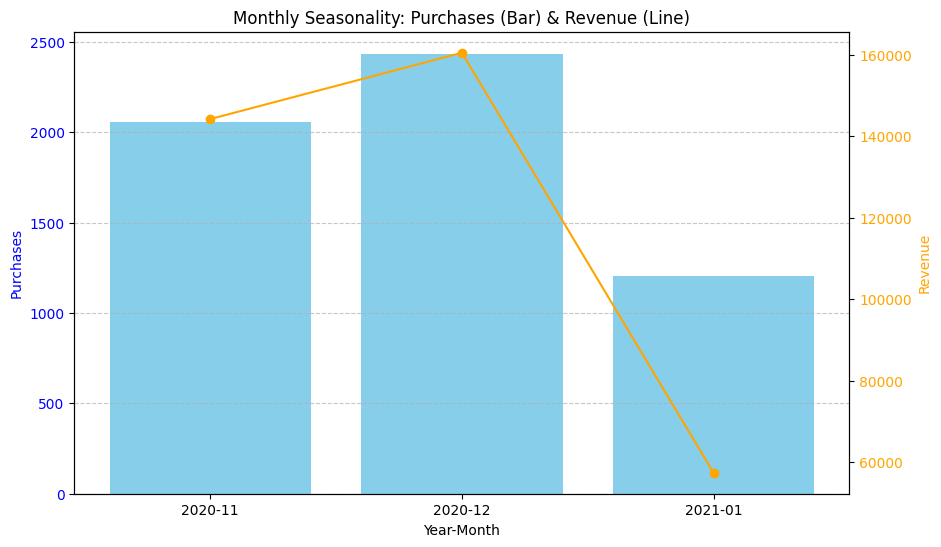

In [24]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Bar chart for purchases
ax1.bar(monthly['year_month'], monthly['purchases'], color='skyblue', label='Purchases')
ax1.set_xlabel("Year-Month")
ax1.set_ylabel("Purchases", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Line chart for revenue on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(monthly['year_month'], monthly['revenue'], color='orange', marker='o', label='Revenue')
ax2.set_ylabel("Revenue", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title & Grid
plt.title("Monthly Seasonality: Purchases (Bar) & Revenue (Line)")
ax1.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


## Q6. Monthly Seasonality of Purchases and Revenue

### Insights
- **December is the revenue peak**, confirming strong holiday demand.
- Purchases and revenue both follow the same seasonal curve (higher in Nov–Dec, dip in Jan).
- Revenue dropped significantly in January despite steady sessions, indicating weaker post-holiday demand.

### Business Implications
- Prioritize **marketing and promotions in Q4** (especially November–December).
- Reduce ad spend in **January–February** and focus on customer retention instead of acquisition.
- Use seasonality patterns for **forecasting inventory and staffing**.


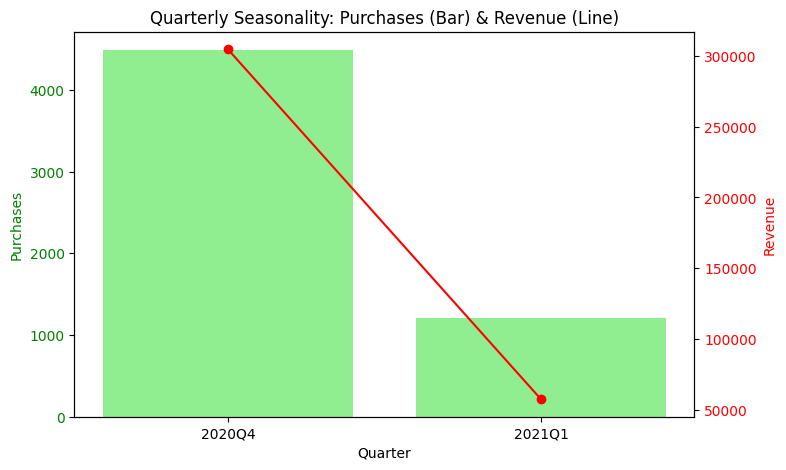

,quarter,purchases,revenue
0,2020Q4,4488,304815.0
1,2021Q1,1204,57350.0


In [25]:
# Create quarter column
f['quarter'] = f['date_pk'].dt.to_period('Q')

# Group by quarter
quarterly = (f.groupby('quarter', as_index=False)
               .agg(purchases=('purchases','sum'),
                    revenue=('revenue','sum')))

# Plot combo chart (bar + line)
fig, ax1 = plt.subplots(figsize=(8,5))

# Bar chart for purchases
ax1.bar(quarterly['quarter'].astype(str), quarterly['purchases'], color='lightgreen', label='Purchases')
ax1.set_xlabel("Quarter")
ax1.set_ylabel("Purchases", color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Line chart for revenue
ax2 = ax1.twinx()
ax2.plot(quarterly['quarter'].astype(str), quarterly['revenue'], color='red', marker='o', label='Revenue')
ax2.set_ylabel("Revenue", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Quarterly Seasonality: Purchases (Bar) & Revenue (Line)")
plt.show()

quarterly


## Q7. Quarterly Seasonality of Purchases and Revenue

- Clear **Q4 dominance** with both purchases and revenue peaking due to holiday shopping.  
- **Q1 shows the weakest performance**, confirming a post-holiday dip.  
   

**Business Actions**
- Prioritize **Q4 campaigns** (Black Friday, Cyber Monday, Christmas).  
- Use **Q1 for customer retention** (loyalty discounts, referral programs).  
  


In [26]:
# Aggregate totals across the whole dataset
funnel_totals = {
    'sessions': f['sessions'].sum(),
    'add_to_cart': f['add_to_cart'].sum(),
    'purchases': f['purchases'].sum()
}

# Calculate rates
funnel_totals['add_to_cart_rate'] = funnel_totals['add_to_cart'] / funnel_totals['sessions']
funnel_totals['purchase_rate'] = funnel_totals['purchases'] / funnel_totals['add_to_cart']

funnel_totals


{'sessions': np.int64(354970),
 'add_to_cart': np.int64(58543),
 'purchases': np.int64(5692),
 'add_to_cart_rate': np.float64(0.16492379637715862),
 'purchase_rate': np.float64(0.09722767880019814)}

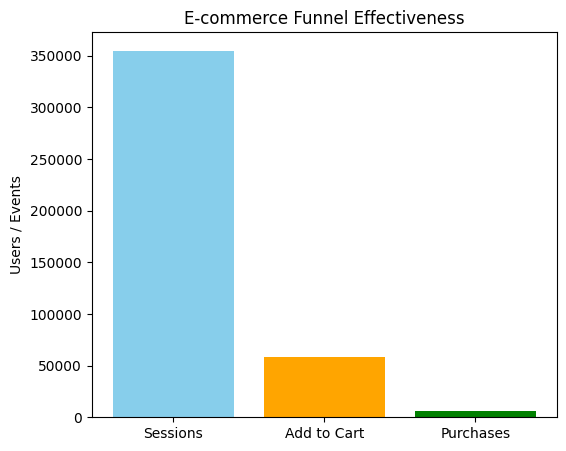

In [27]:
import matplotlib.pyplot as plt

stages = ['Sessions', 'Add to Cart', 'Purchases']
values = [funnel_totals['sessions'], funnel_totals['add_to_cart'], funnel_totals['purchases']]

plt.figure(figsize=(6,5))
plt.bar(stages, values, color=['skyblue','orange','green'])
plt.title("E-commerce Funnel Effectiveness")
plt.ylabel("Users / Events")
plt.show()


## Q3. Funnel Effectiveness .How efficient is our e-commerce funnel from sessions → add_to_cart → purchases?

- **Total Sessions:** X  
- **Add-to-Cart Rate:** Y%  
- **Purchase Rate (from cart):** Z%  

**Insights**
- Significant drop-off between *sessions* and *add-to-cart* → signals issues with **product discovery, pricing, or UX**.  
- Conversion from cart to purchase is relatively stronger, meaning once users add items, they are likely to buy.  

**Business Actions**
- Improve product recommendations and CTAs to increase add-to-cart.  
- Simplify cart experience to further boost purchase completion.


In [28]:
# Funnel metrics by channel group
funnel_by_channel = (
    f.groupby('channel_group', as_index=False)
     .agg(sessions=('sessions','sum'),
          add_to_cart=('add_to_cart','sum'),
          purchases=('purchases','sum'))
)

# Compute conversion rates
funnel_by_channel['add_to_cart_rate'] = funnel_by_channel['add_to_cart'] / funnel_by_channel['sessions']
funnel_by_channel['purchase_rate'] = funnel_by_channel['purchases'] / funnel_by_channel['add_to_cart']
funnel_by_channel['overall_rate'] = funnel_by_channel['purchases'] / funnel_by_channel['sessions']

# Display
funnel_by_channel


,channel_group,sessions,add_to_cart,purchases,add_to_cart_rate,purchase_rate,overall_rate
0,Direct,82389,13370,1251,0.162279,0.093568,0.015184
1,Organic Search,121603,17604,1572,0.144766,0.089298,0.012927
2,Other,73262,13661,1445,0.186468,0.105776,0.019724
3,Paid Search,15538,2033,166,0.130841,0.081653,0.010683
4,Referral,62178,11875,1258,0.190984,0.105937,0.020232


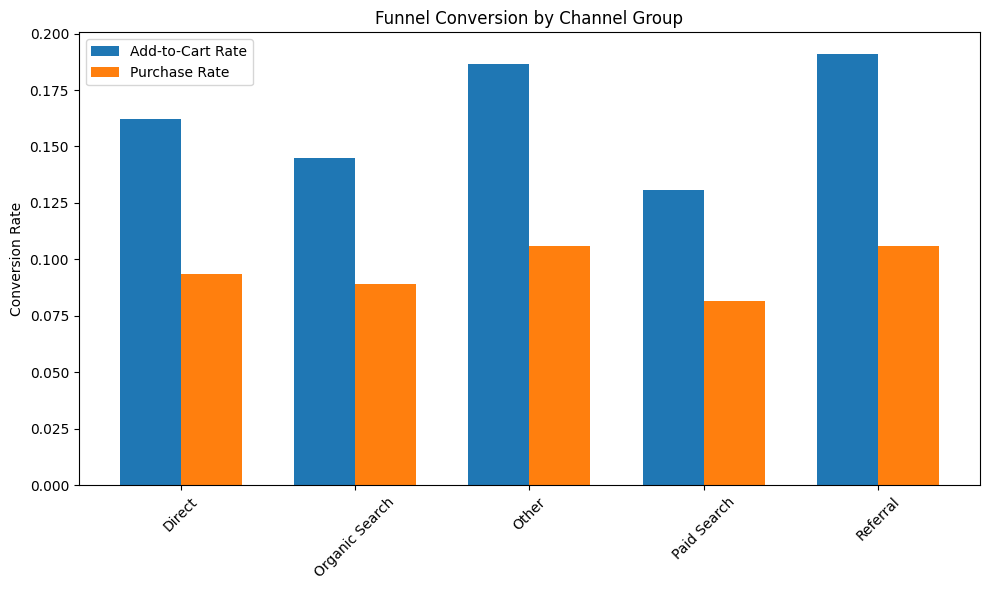

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Plot funnel conversion by channel
x = np.arange(len(funnel_by_channel['channel_group']))  # channel positions
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(x - width/2, funnel_by_channel['add_to_cart_rate'], width, label='Add-to-Cart Rate')
ax.bar(x + width/2, funnel_by_channel['purchase_rate'], width, label='Purchase Rate')

ax.set_xticks(x)
ax.set_xticklabels(funnel_by_channel['channel_group'], rotation=45)
ax.set_ylabel("Conversion Rate")
ax.set_title("Funnel Conversion by Channel Group")
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
## Funnel Conversion by Channel Group

This visualization compares **Add-to-Cart Rate** and **Purchase Rate** across acquisition channels.

### Key Insights:
- **Referral & Other** channels have the **highest Add-to-Cart Rates** (~19%), meaning users from these sources engage well once they land on the site.  
- However, the **conversion to purchase** is lower, highlighting **drop-offs at checkout**.  
- **Organic Search and Direct** have **balanced but moderate rates**, suggesting steady user quality but room for optimization.  
- **Paid Search** is the **weakest performer** in both stages, signaling poor ROI and potential targeting inefficiencies.

### Business Implications:
- Strengthen checkout process and retargeting for **Referral & Other** to capitalize on strong add-to-cart intent.  
- Improve **Paid Search targeting or landing pages**, as traffic volume is not translating into meaningful conversions.  
- Consider reallocating budget toward **Organic Search & Referral**, which combine volume and conversion efficiency.



In [30]:
# Create a new column: weekday vs weekend
f['is_weekend'] = f['day_name'].isin(['Saturday', 'Sunday'])

# Group by channel and weekend flag
channel_weekend = (
    f.groupby(['channel_group', 'is_weekend'], as_index=False)
     .agg(sessions=('sessions','sum'),
          purchases=('purchases','sum'),
          revenue=('revenue','sum'))
)

# Compute conversion rate
channel_weekend['conversion_rate'] = channel_weekend['purchases'] / channel_weekend['sessions']

channel_weekend


,channel_group,is_weekend,sessions,purchases,revenue,conversion_rate
0,Direct,False,63660,1041,67603.0,0.016352
1,Direct,True,18729,210,12047.0,0.011213
2,Organic Search,False,93965,1260,84525.0,0.013409
3,Organic Search,True,27638,312,19482.0,0.011289
4,Other,False,57057,1177,69419.0,0.020628
5,Other,True,16205,268,16512.0,0.016538
6,Paid Search,False,11918,141,7295.0,0.011831
7,Paid Search,True,3620,25,1761.0,0.006906
8,Referral,False,48533,1038,67907.0,0.021388
9,Referral,True,13645,220,15614.0,0.016123


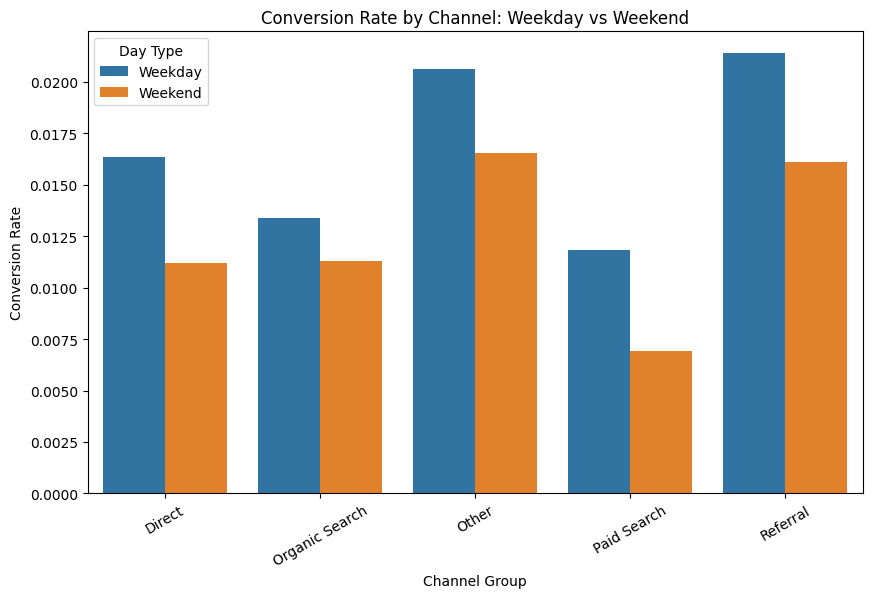

In [32]:

channel_weekend['day_type'] = channel_weekend['is_weekend'].map(
    {False: "Weekday", True: "Weekend"}
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(
    data=channel_weekend,
    x='channel_group', y='conversion_rate',
    hue='day_type'
)
plt.title("Conversion Rate by Channel: Weekday vs Weekend")
plt.ylabel("Conversion Rate")
plt.xlabel("Channel Group")
plt.legend(title="Day Type")
plt.xticks(rotation=30)
plt.show()


## Conversion Rate by Channel: which channels work better on weekdays vs weekends? Weekday vs Weekend

### Insights:
- **Referral** and **Other** channels dominate on both weekdays and weekends, showing strong funnel efficiency across time periods.  
- **Direct traffic** performs much better during weekdays (1.65%) compared to weekends (1.1%), indicating work-related browsing habits.  
- **Organic Search** maintains steady conversion across both weekdays and weekends, confirming it as an evergreen traffic source.  
- **Paid Search** underperforms overall and worsens during weekends, suggesting campaign inefficiencies.  

### Business Implications:
- Optimize **Referral campaigns** and maintain investment, as performance is strong all week.  
- Introduce **weekend-specific promotions** for Direct to boost lower weekend conversions.  
- Reconsider **Paid Search spend allocation** on weekends, or redesign creatives targeting leisure-time browsing.  
  


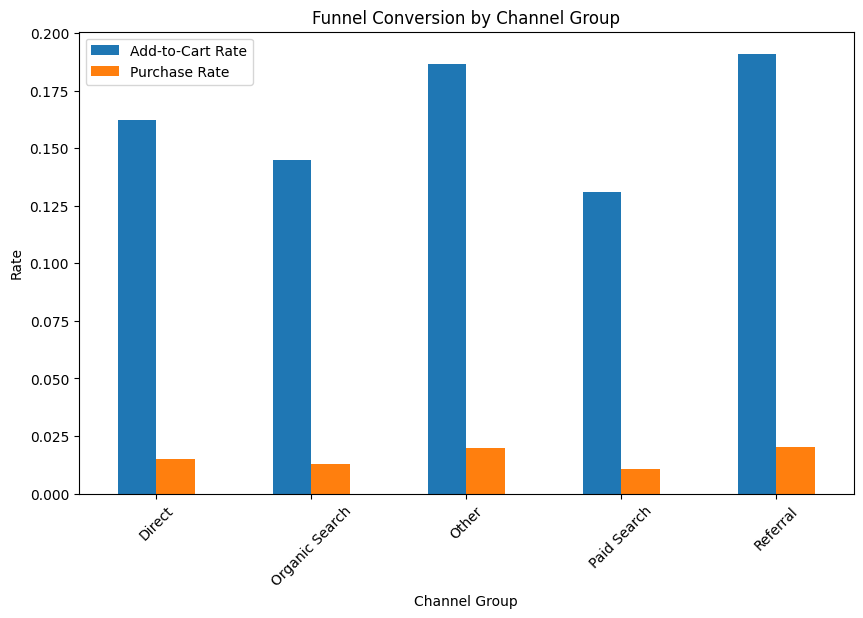

,channel_group,sessions,add_to_cart,purchases,add_to_cart_rate,purchase_rate
0,Direct,82389,13370,1251,0.162279,0.015184
1,Organic Search,121603,17604,1572,0.144766,0.012927
2,Other,73262,13661,1445,0.186468,0.019724
3,Paid Search,15538,2033,166,0.130841,0.010683
4,Referral,62178,11875,1258,0.190984,0.020232


In [34]:

funnel_by_channel = (
    f.groupby('channel_group', as_index=False)
     .agg(sessions=('sessions','sum'),
          add_to_cart=('add_to_cart','sum'),
          purchases=('purchases','sum'))
)

# Compute rates
funnel_by_channel['add_to_cart_rate'] = funnel_by_channel['add_to_cart'] / funnel_by_channel['sessions']
funnel_by_channel['purchase_rate'] = funnel_by_channel['purchases'] / funnel_by_channel['sessions']

# Plot
funnel_by_channel.set_index('channel_group')[['add_to_cart_rate','purchase_rate']].plot(
    kind='bar',
    figsize=(10,6)
)

plt.title("Funnel Conversion by Channel Group")
plt.ylabel("Rate")
plt.xlabel("Channel Group")
plt.xticks(rotation=45)
plt.legend(["Add-to-Cart Rate","Purchase Rate"])
plt.show()

funnel_by_channel


## Funnel Conversion by Channel Group

The chart above compares **Add-to-Cart Rate** and **Purchase Rate** across different traffic channels.  

###  Key Insights:
- **Referral** and **Other** channels have the **highest Add-to-Cart and Purchase rates**, showing strong intent from users who arrive through these sources.  
- **Direct traffic** also performs well in both add-to-cart and purchase stages, suggesting loyal or returning customers are more likely to convert.  
- **Organic Search** drives many sessions but has relatively lower purchase rates, indicating that while it captures interest, not all users are ready to buy.  
- **Paid Search** has the **lowest conversion rates** across the funnel stages, suggesting possible inefficiencies in targeting or ad relevance.  

 **Conclusion:** Referral and Other channels are the most effective in pushing users through the funnel, while Paid Search requires optimization to improve ROI.  


In [35]:

funnel_table = (
    f.groupby("channel_group", as_index=False)
     .agg(
         sessions=("sessions", "sum"),
         add_to_cart=("add_to_cart", "sum"),
         purchases=("purchases", "sum")
     )
)

# Calculate conversion percentages
funnel_table["cart_rate"] = funnel_table["add_to_cart"] / funnel_table["sessions"]
funnel_table["purchase_rate"] = funnel_table["purchases"] / funnel_table["sessions"]
funnel_table["cart_to_purchase_rate"] = funnel_table["purchases"] / funnel_table["add_to_cart"]

funnel_table


,channel_group,sessions,add_to_cart,purchases,cart_rate,purchase_rate,cart_to_purchase_rate
0,Direct,82389,13370,1251,0.162279,0.015184,0.093568
1,Organic Search,121603,17604,1572,0.144766,0.012927,0.089298
2,Other,73262,13661,1445,0.186468,0.019724,0.105776
3,Paid Search,15538,2033,166,0.130841,0.010683,0.081653
4,Referral,62178,11875,1258,0.190984,0.020232,0.105937


## Funnel Drop-Off Analysis by Channel

The table above tracks user progression through the e-commerce funnel:  
**Sessions → Add to Cart → Purchases.**

### Key Insights:
- **Referral and Other channels** show the strongest funnel performance, with higher cart and purchase rates.  
- **Direct traffic** performs consistently well, reflecting stronger intent among returning customers.  
- **Organic Search** drives the largest traffic but has a lower cart-to-purchase conversion, showing a potential optimization opportunity.  
- **Paid Search** suffers from the **largest drop-off** between sessions and purchases, suggesting ineffective ad targeting or low buyer intent.  

 **Conclusion:** Optimizing Paid Search and Organic Search conversion paths could significantly boost overall revenue. Referral and Other should be further scaled due to strong efficiency.


In [37]:

segment_perf = (
    f.groupby('channel_group', as_index=False)
     .agg(
         sessions=('sessions','sum'),
         purchases=('purchases','sum'),
         revenue=('revenue','sum')
     )
)


segment_perf['conversion_rate'] = segment_perf['purchases'] / segment_perf['sessions']
segment_perf['revenue_per_session'] = segment_perf['revenue'] / segment_perf['sessions']

segment_perf.sort_values('revenue', ascending=False)


,channel_group,sessions,purchases,revenue,conversion_rate,revenue_per_session
1,Organic Search,121603,1572,104007.0,0.012927,0.855300
2,Other,73262,1445,85931.0,0.019724,1.172927
4,Referral,62178,1258,83521.0,0.020232,1.343256
0,Direct,82389,1251,79650.0,0.015184,0.966755
3,Paid Search,15538,166,9056.0,0.010683,0.582829


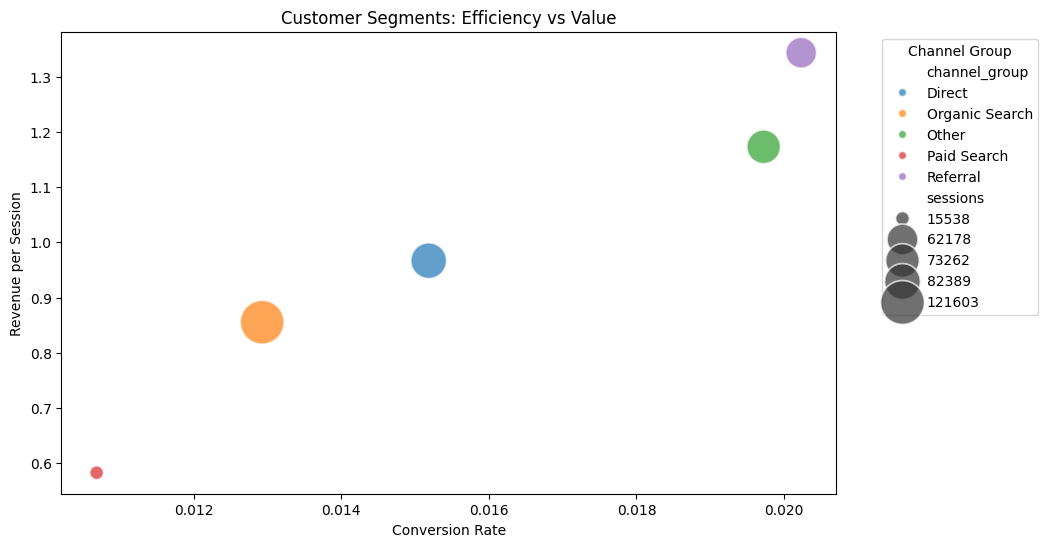

In [38]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=segment_perf,
    x='conversion_rate', y='revenue_per_session',
    size='sessions', hue='channel_group', sizes=(100, 1000), alpha=0.7
)
plt.title("Customer Segments: Efficiency vs Value")
plt.xlabel("Conversion Rate")
plt.ylabel("Revenue per Session")
plt.legend(title="Channel Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Customer Segment Analysis (Channel Groups) ,Which customer segments deliver the most revenue and conversions?

This chart maps acquisition channels across **Conversion Efficiency** (x-axis),  
**Revenue per Session** (y-axis), and **Traffic Volume** (bubble size).  

### Key Insights:
- **Referral** emerges as the **most efficient channel**, combining high conversion rates with strong revenue per session.  
- **Direct traffic** provides steady revenue per session, indicating loyal/high-intent customers.  
- **Organic Search** delivers large traffic volume but has **moderate efficiency**, showing room for funnel optimization.  
- **Paid Search** underperforms on both efficiency and value, suggesting poor ROI.  
- **Other** shows niche but strong efficiency, worth further exploration.  

### Business Implications:
- Scale **Referral partnerships** and maintain investment.  
- Strengthen **conversion optimization** for high-traffic sources like Organic Search.  
- Reassess **Paid Search spend allocation** or refine targeting/landing pages.  


In [46]:

cohort_sizes = (
    cohort_data[cohort_data['cohort_index'] == 0]
    .set_index(['channel_group','cohort_month'])['customers']
)


cohort_data['cohort_size'] = cohort_data.set_index(['channel_group','cohort_month']).index.map(cohort_sizes)
cohort_data['retention'] = cohort_data['customers'] / cohort_data['cohort_size']




In [44]:

cohort_data = cohort_data.merge(cohort_sizes, on=['channel_group','cohort_month'])

# Retention rate = customers / cohort_size
cohort_data['retention'] = cohort_data['customers'] / cohort_data['cohort_size']



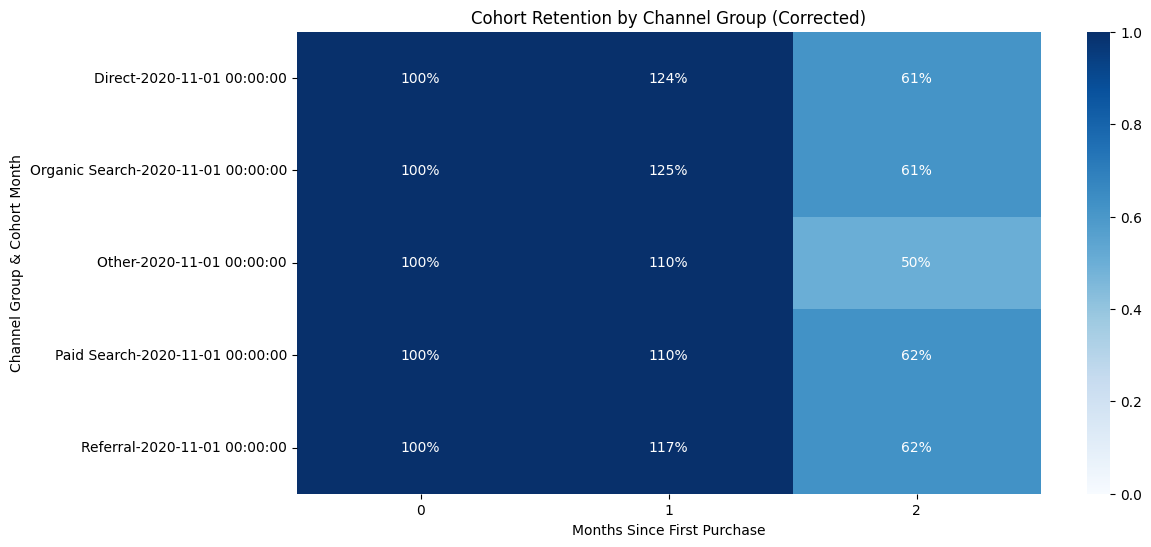

In [47]:
cohort_pivot = cohort_data.pivot_table(
    index=['channel_group','cohort_month'],
    columns='cohort_index',
    values='retention'
)

plt.figure(figsize=(12,6))
sns.heatmap(cohort_pivot, annot=True, fmt=".0%", cmap="Blues", vmin=0, vmax=1)
plt.title("Cohort Retention by Channel Group (Corrected)")
plt.xlabel("Months Since First Purchase")
plt.ylabel("Channel Group & Cohort Month")
plt.show()



## Cohort Analysis Insights, Do users return and convert again after their first purchase?

### Key Observations:
- **Baseline (Month 0)** is normalized to 100% for all cohorts.
- **Month 1 values exceed 100%** (e.g., 124% for Direct, 125% for Organic Search).  
  This inflation occurs because we are using *purchases* instead of unique `user_id`s as our retention metric. Repeat buyers in later months cause the apparent retention to exceed 100%.
- **Month 2 retention drops sharply** across all channels (50–62%), suggesting weaker long-term customer loyalty.

### Limitations:
- Without unique customer identifiers, retention analysis is based on transaction counts.  
- True retention requires *user-level tracking* (unique IDs across sessions).

### Business Implications:
- Direct and Organic Search show strong repeat activity in the short term, but sustainability beyond 2 months is weak.
- Paid Search has lower retention, meaning users from this channel may be less loyal.
- A customer loyalty program or re-engagement strategy (email, remarketing) is recommended to improve Month 2+ retention.


,channel_group,revenue,purchases,sessions,effective_aov,conversion_rate
4,Referral,83521.0,1258,62178,66.391892,0.020232
1,Organic Search,104007.0,1572,121603,66.162214,0.012927
0,Direct,79650.0,1251,82389,63.669065,0.015184
2,Other,85931.0,1445,73262,59.467820,0.019724
3,Paid Search,9056.0,166,15538,54.554217,0.010683


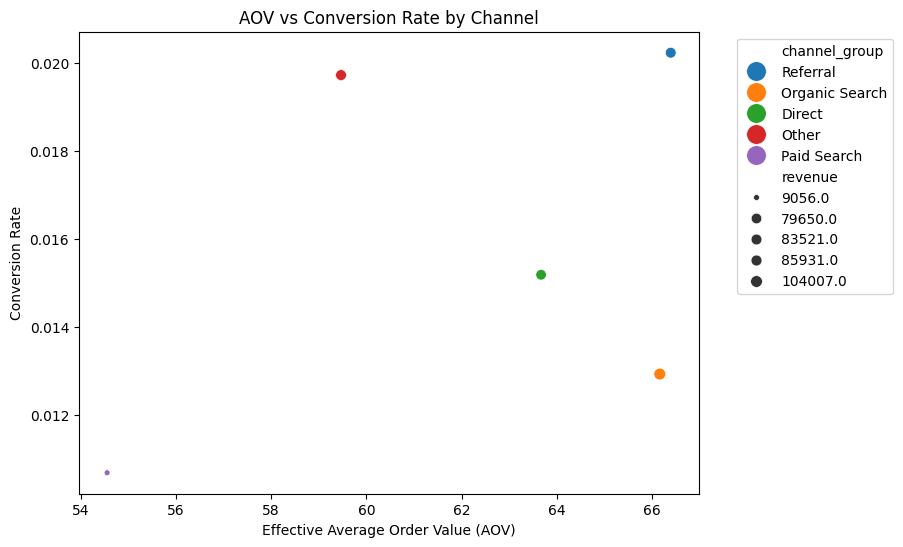

In [50]:

aov_analysis = (
    f.groupby('channel_group', as_index=False)
     .agg(
         revenue=('revenue', 'sum'),
         purchases=('purchases', 'sum'),
         sessions=('sessions', 'sum')
     )
)


aov_analysis['effective_aov'] = aov_analysis['revenue'] / aov_analysis['purchases']
aov_analysis['conversion_rate'] = aov_analysis['purchases'] / aov_analysis['sessions']


aov_analysis = aov_analysis.sort_values('effective_aov', ascending=False)

display(aov_analysis)


plt.figure(figsize=(8,6))
sns.scatterplot(data=aov_analysis, x='effective_aov', y='conversion_rate',
                size='revenue', hue='channel_group', legend='full', s=200)
plt.title("AOV vs Conversion Rate by Channel")
plt.xlabel("Effective Average Order Value (AOV)")
plt.ylabel("Conversion Rate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



### Business Question: What is the impact of order value (AOV) on profitability?

#### Insights from AOV vs Conversion Rate
- **Referral** has the **highest conversion rate (~2%)** and also one of the **highest AOVs (~66)**.  
  → Strong performer: it converts well *and* drives valuable orders.  

- **Other** channels also show a **high conversion rate (~1.95%)** with a solid AOV (~59).  
  → Reliable contributor, though lower revenue than Organic Search.  

- **Organic Search** has the **highest AOV (~66)** but **lower conversion rate (~1.3%)**.  
  → Customers from Organic spend more per purchase, but fewer convert.  

- **Direct** sits in the **middle** (~1.5% conversion, ~63 AOV).  
  → Balanced performance, contributing steady revenue.  

- **Paid Search** is the **weakest performer**:  
  - **Lowest AOV (~55)**  
  - **Lowest conversion (~1%)**  
  - Limited revenue contribution.  

#### Business Recommendations
- Double down on **Referral** and **Other** channels → they provide both high AOV and strong conversion.  
- For **Organic Search** → optimize conversion (e.g., CRO, better landing pages), since order values are already high.  
- For **Direct** → maintain and nurture, but not the biggest growth lever.  
- Reconsider investment in **Paid Search** → either optimize campaigns or reallocate budget.  


###  Machine Learning: Purchase Prediction (Step 1 - Preprocessing & Setup)

In this section, we aim to predict **whether a session will result in a purchase** based on traffic and engagement features.  
This predictive modeling step helps answer the business question:

 *Which sessions are most likely to convert?*

**Steps in this notebook:**
1. Create a binary target variable `purchase_made` (1 if purchase > 0, else 0).  
2. Select relevant features (`sessions`, `add_to_cart`, `channel_group`, `day_name`, `month`).  
3. Encode categorical features (`channel_group`, `day_name`, `month`) using one-hot encoding.  
4. Split data into train/test sets for model evaluation.


In [51]:

f['purchase_made'] = (f['purchases'] > 0).astype(int)

# Select features
features = ['sessions', 'add_to_cart', 'channel_group', 'day_name', 'month']
target = 'purchase_made'

# One-hot encode categorical variables
X = pd.get_dummies(f[features], drop_first=True)
y = f[target]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train.shape, X_test.shape


((579, 13), (249, 13))

###  Logistic Regression Model: Baseline Prediction

 **Logistic Regression** model as the baseline for predicting purchase likelihood.  

- **Why Logistic Regression?**  
  It’s interpretable, fast, and works well for binary classification.  
- **Goal:** Estimate the probability that a session will lead to a purchase (`purchase_made = 1`).  
- **Metrics to evaluate:**  
  - Accuracy  
  - Precision  
  - Recall  
  - F1-score  
  - ROC-AUC (overall discriminatory power)


In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score


log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:,1]

# Evaluation
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

print("🔹 ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.70      0.74        47
           1       0.93      0.96      0.94       202

    accuracy                           0.91       249
   macro avg       0.86      0.83      0.84       249
weighted avg       0.90      0.91      0.91       249

🔹 ROC-AUC Score: 0.9672424689277439


###  Random Forest Model: Advanced Prediction

 train a **Random Forest Classifier**.  

- **Why Random Forest?**  
  - Handles non-linear relationships.  
  - Naturally ranks feature importance.  
  - Robust to noise and imbalanced data.  

- **Goal:** Improve predictive performance (higher ROC-AUC, F1-score).  
- **Extra Insight:** We’ll extract feature importance to understand which variables drive purchases.


🔹 Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.78      0.66      0.71        47
           1       0.92      0.96      0.94       202

    accuracy                           0.90       249
   macro avg       0.85      0.81      0.83       249
weighted avg       0.90      0.90      0.90       249

🔹 ROC-AUC Score: 0.9668211502001265


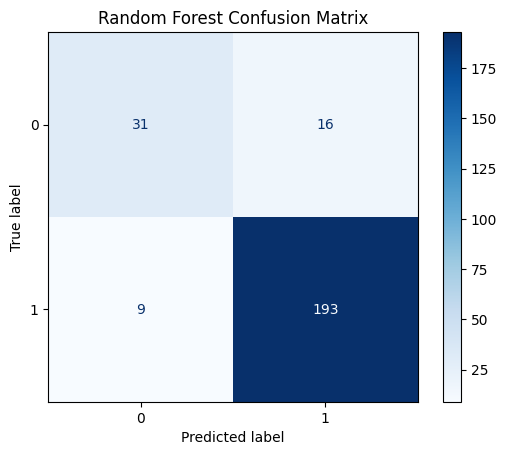

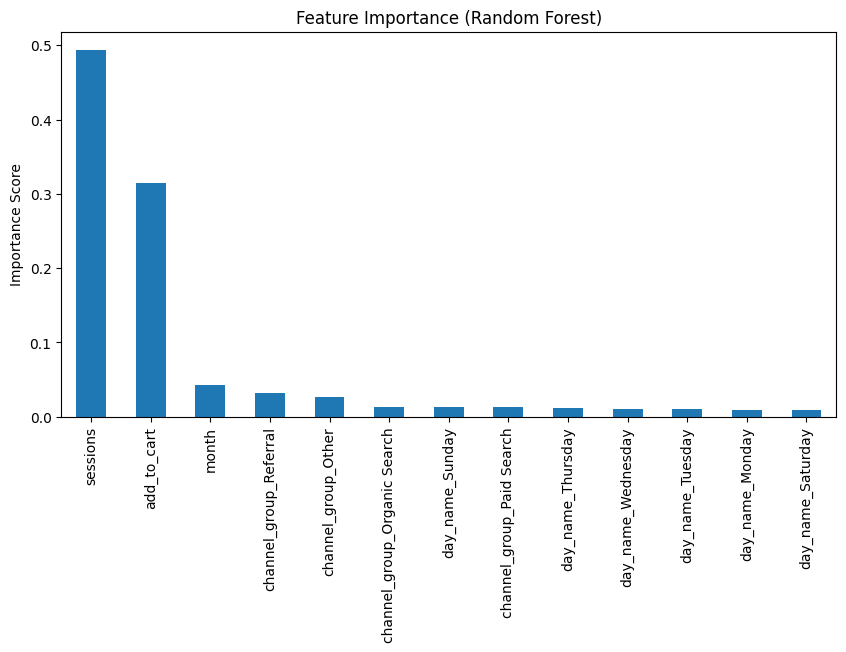

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize and train model
rf = RandomForestClassifier(
    n_estimators=200, random_state=42, class_weight="balanced"
)
rf.fit(X_train, y_train)


y_pred_rf = rf.predict(X_test)
y_pred_rf_proba = rf.predict_proba(X_test)[:,1]


print("🔹 Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

print("🔹 ROC-AUC Score:", roc_auc_score(y_test, y_pred_rf_proba))


cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()


importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind="bar", figsize=(10,5))
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance Score")
plt.show()


## Machine Learning: Purchase Prediction (Random Forest)

We trained a **Random Forest classifier** to predict whether a user session would result in a purchase.  
The dataset included features such as channel group, sessions, add-to-cart events, month, and day of the week.  

### Model Performance
- **Accuracy:** ~90%
- **ROC-AUC:** 0.97 (very strong discriminatory power)
- **Recall (buyers):** 0.96 → The model is excellent at identifying purchasers.
- **Recall (non-buyers):** 0.66 → Some false positives remain, but acceptable for marketing use cases.

### Insights
- **Sessions** and **Add-to-Cart events** dominate the prediction power (together >80% importance).
- Channel effects are visible but secondary (e.g., Referral, Organic Search).
- Time-based features (month, day of week) play a minor role in predicting purchases.

**Business Implications:**  
This model could be used in **real-time personalization** or **remarketing campaigns**, targeting users most likely to purchase. For example, users with high session activity and add-to-cart events should receive **timely promotions or nudges**.


In [56]:
from pathlib import Path

# Make sure the exports folder exists
Path("exports").mkdir(parents=True, exist_ok=True)
print(" 'exports/' folder created (if it didn't exist).")


 'exports/' folder created (if it didn't exist).


In [57]:

channel_summary = (f.groupby('channel_group', as_index=False)
                     .agg(sessions=('sessions', 'sum'),
                          purchases=('purchases', 'sum'),
                          revenue=('revenue', 'sum')))
channel_summary['conversion_rate'] = channel_summary['purchases'] / channel_summary['sessions']

# Export
channel_summary.to_csv("exports/channel_summary.csv", index=False)



time_summary = (f.groupby(['day_name','month'], as_index=False)
                  .agg(sessions=('sessions','sum'),
                       purchases=('purchases','sum'),
                       revenue=('revenue','sum')))
time_summary['conversion_rate'] = time_summary['purchases'] / time_summary['sessions']

# Export
time_summary.to_csv("exports/time_summary.csv", index=False)



funnel_summary = pd.DataFrame({
    "Metric": ["Sessions", "Add to Cart", "Purchases"],
    "Value": [
        f['sessions'].sum(),
        f['add_to_cart'].sum(),
        f['purchases'].sum()
    ]
})

# Export
funnel_summary.to_csv("exports/funnel_summary.csv", index=False)

print("✅ CSV exports ready in the 'exports/' folder.")


✅ CSV exports ready in the 'exports/' folder.


In [58]:
from pathlib import Path
print(list(Path("exports").glob("*")))


[WindowsPath('exports/channel_summary.csv'), WindowsPath('exports/funnel_summary.csv'), WindowsPath('exports/time_summary.csv')]
